In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import recall_score, classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif

In [13]:
df = pd.read_csv('../data/heart_disease_clean.csv', index_col='id')

In [14]:
df.drop(['heart_disease_gravity', 'dataset'], axis=1, inplace=True)
df.head()

,age,sex,chest_pain_type,blood_pressure_resting,cholesterol,fasting_blood_sugar,ecg_resting,max_heart_rate,exercise_induced_angina,st_depression_exercise,st_slope_type,major_vessels_colored,thal_defect_type,sick
id,,,,,,,,,,,,,,
1,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
2,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,1
3,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
4,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
5,41,Female,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [15]:
X = df.drop('sick', axis=1)
y = df['sick']

# Preserve the original X_train and X_test DataFrames for column name extraction
# before they are potentially overwritten as NumPy arrays by the preprocessor.
X_train_original, X_test_original, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Identify categorical and numerical columns from the ORIGINAL (pre-split and pre-transform) DataFrames
numerical_cols = X_train_original.select_dtypes(include=['number']).columns.tolist()
categorical_cols = [col for col in X_train_original.columns if col not in numerical_cols]


if categorical_cols:
    print(f"Applying One-Hot Encoding to: {categorical_cols}")

    # Use ColumnTransformer for robust encoding of specific columns
    # 'passthrough' keeps other numerical columns.
    # The order of columns in the output will be: one-hot encoded features first, then passthrough numerical features.
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
        ],
        remainder='passthrough'
    )

    # Fit and transform on training data.
    # The output of fit_transform/transform is a NumPy array.
    X_train_transformed_array = preprocessor.fit_transform(X_train_original) # Fit on original X_train
    X_test_transformed_array = preprocessor.transform(X_test_original)       # Transform original X_test

    # Get new column names:
    # 1. Names from one-hot encoded features
    ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
    
    # 2. Names from the numerical (passthrough) features
    # These are simply the numerical_cols identified from the original DataFrame
    passthrough_feature_names = numerical_cols 

    # Combine feature names in the correct order as output by ColumnTransformer:
    # OHE features first, then passthrough features.
    new_column_names = list(ohe_feature_names) + list(passthrough_feature_names)

    # Convert back to DataFrame with proper column names and original indices
    # Now, assign the results back to X_train and X_test
    X_train = pd.DataFrame(X_train_transformed_array, columns=new_column_names, index=X_train_original.index)
    X_test = pd.DataFrame(X_test_transformed_array, columns=new_column_names, index=X_test_original.index)

    print(f"One-Hot encoded {len(categorical_cols)} columns, resulting in {len(ohe_feature_names)} new features from categorical columns.")
    print(f"Total features after encoding: {X_train.shape[1]}")
    print("\nFirst 5 rows of X_train (after encoding):")
else:
    print("No categorical columns found for One-Hot Encoding.")

X_train.head()

Applying One-Hot Encoding to: ['sex', 'chest_pain_type', 'fasting_blood_sugar', 'ecg_resting', 'exercise_induced_angina', 'st_slope_type', 'thal_defect_type']
One-Hot encoded 7 columns, resulting in 19 new features from categorical columns.
Total features after encoding: 25

First 5 rows of X_train (after encoding):


,sex_Female,sex_Male,chest_pain_type_asymptomatic,chest_pain_type_atypical angina,chest_pain_type_non-anginal,chest_pain_type_typical angina,fasting_blood_sugar_False,fasting_blood_sugar_True,ecg_resting_lv hypertrophy,ecg_resting_normal,...,st_slope_type_upsloping,thal_defect_type_fixed defect,thal_defect_type_normal,thal_defect_type_reversable defect,age,blood_pressure_resting,cholesterol,max_heart_rate,st_depression_exercise,major_vessels_colored
id,,,,,,,,,,,,,,,,,,,,,
206,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,45.0,142.0,309.0,147.0,0.0,3.0
219,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,64.0,130.0,303.0,122.0,2.0,2.0
187,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,42.0,120.0,240.0,194.0,0.8,0.0
96,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,52.0,128.0,255.0,161.0,0.0,1.0
135,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,43.0,122.0,213.0,165.0,0.2,0.0


In [16]:
X_train.columns

Index(['sex_Female', 'sex_Male', 'chest_pain_type_asymptomatic',
       'chest_pain_type_atypical angina', 'chest_pain_type_non-anginal',
       'chest_pain_type_typical angina', 'fasting_blood_sugar_False',
       'fasting_blood_sugar_True', 'ecg_resting_lv hypertrophy',
       'ecg_resting_normal', 'ecg_resting_st-t abnormality',
       'exercise_induced_angina_False', 'exercise_induced_angina_True',
       'st_slope_type_downsloping', 'st_slope_type_flat',
       'st_slope_type_upsloping', 'thal_defect_type_fixed defect',
       'thal_defect_type_normal', 'thal_defect_type_reversable defect', 'age',
       'blood_pressure_resting', 'cholesterol', 'max_heart_rate',
       'st_depression_exercise', 'major_vessels_colored'],
      dtype='object')

In [17]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (209, 25)
X_test shape: (90, 25)
y_train shape: (209,)
y_test shape: (90,)


In [18]:
# Check the distribution of 'sick' in train and test sets
print("\n'sick' distribution in y_train:")
print(y_train.value_counts(normalize=True))
print("\n'sick' distribution in y_test:")
print(y_test.value_counts(normalize=True))


'sick' distribution in y_train:
sick
0    0.535885
1    0.464115
Name: proportion, dtype: float64

'sick' distribution in y_test:
sick
0    0.533333
1    0.466667
Name: proportion, dtype: float64


## Feature Scaling

In [19]:
scaler = StandardScaler()

# Fit on training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames with proper column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

## Model Training

We will train several classification models: RandomForestClassifier (scale-insensitive), KNeighborsClassifier, LogisticRegression, and Support Vector Classifier (SVC) (scale-sensitive).


In [20]:
# 1. Random Forest Classifier (Scale-Insensitive)
print("Training Random Forest Classifier...")
forest = RandomForestClassifier(random_state=42) # Add random_state for reproducibility
forest.fit(X_train, y_train)
print("Random Forest Classifier trained.")

# 2. K-Nearest Neighbors Classifier (Scale-Sensitive)
print("\nTraining K-Nearest Neighbors Classifier...")
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
print("K-Nearest Neighbors Classifier trained.")

# 3. Logistic Regression (Scale-Sensitive)
print("\nTraining Logistic Regression...")
log = LogisticRegression(random_state=42, solver='liblinear') # Add random_state and solver
log.fit(X_train_scaled, y_train)
print("Logistic Regression trained.")

# 4. Support Vector Classifier (SVC) (Scale-Sensitive)
print("\nTraining Support Vector Classifier...")
svc = SVC(random_state=42, probability=True) # probability=True for ROC AUC later
svc.fit(X_train_scaled, y_train)
print("Support Vector Classifier trained.")


Training Random Forest Classifier...
Random Forest Classifier trained.

Training K-Nearest Neighbors Classifier...
K-Nearest Neighbors Classifier trained.

Training Logistic Regression...
Logistic Regression trained.

Training Support Vector Classifier...
Support Vector Classifier trained.


## Initial Model Evaluation (Before Tuning)

In [21]:
print("--- Initial Model Scores (Accuracy) ---")
print(f"Random Forest Accuracy: {forest.score(X_test, y_test):.3f}")
print(f"K-Nearest Neighbors Accuracy: {knn.score(X_test_scaled, y_test):.3f}")
print(f"Logistic Regression Accuracy: {log.score(X_test_scaled, y_test):.3f}")
print(f"Support Vector Classifier Accuracy: {svc.score(X_test_scaled, y_test):.3f}")


--- Initial Model Scores (Accuracy) ---
Random Forest Accuracy: 0.811
K-Nearest Neighbors Accuracy: 0.822
Logistic Regression Accuracy: 0.822
Support Vector Classifier Accuracy: 0.789


In [22]:
# It's also good to see recall, especially for medical diagnoses where false negatives can be critical.
print("\n--- Initial Model Scores (Recall) ---")

y_preds_forest = forest.predict(X_test)
print(f"Random Forest Recall: {recall_score(y_test, y_preds_forest):.3f}")

y_preds_knn = knn.predict(X_test_scaled)
print(f"K-Nearest Neighbors Recall: {recall_score(y_test, y_preds_knn):.3f}")

y_preds_log = log.predict(X_test_scaled)
print(f"Logistic Regression Recall: {recall_score(y_test, y_preds_log):.3f}")

y_preds_svc = svc.predict(X_test_scaled)
print(f"Support Vector Classifier Recall: {recall_score(y_test, y_preds_svc):.3f}")


--- Initial Model Scores (Recall) ---
Random Forest Recall: 0.714
K-Nearest Neighbors Recall: 0.762
Logistic Regression Recall: 0.738
Support Vector Classifier Recall: 0.643


## Hyperparameter Tuning with GridSearchCV

In [23]:
# Random Forest tuning
print("\nTuning Random Forest Classifier...")
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Using 'recall' as the scoring metric for medical diagnosis, as minimizing false negatives is often crucial.
# If you want to optimize for overall accuracy, keep 'accuracy'.
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='recall', n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)

print("\nRandom Forest Best Parameters:", rf_grid.best_params_)
print(f"Random Forest Best Score (Recall on CV):  {rf_grid.best_score_:.3f}")
best_forest_model = rf_grid.best_estimator_



Tuning Random Forest Classifier...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Random Forest Best Parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Best Score (Recall on CV):  0.807


In [24]:
# KNN tuning
print("\nTuning K-Nearest Neighbors Classifier...")
knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='recall', n_jobs=-1, verbose=1)
knn_grid.fit(X_train_scaled, y_train)

print("\nKNN Best Parameters:", knn_grid.best_params_)
print(f"KNN Best Score (Recall on CV): {knn_grid.best_score_:.3f}")
best_knn_model = knn_grid.best_estimator_


Tuning K-Nearest Neighbors Classifier...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

KNN Best Parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
KNN Best Score (Recall on CV): 0.796


In [25]:
# Logistic Regression tuning
print("\nTuning Logistic Regression Classifier...")
# This is a cleaner way to define parameter grids with conditional parameters
log_params = [
    {
        'solver': ['liblinear'],
        'penalty': ['l1', 'l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100]
    },
    {
        'solver': ['lbfgs'],
        'penalty': ['l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100]
    }
]

log_grid = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000), log_params, cv=5, scoring='recall', n_jobs=-1, verbose=1)
log_grid.fit(X_train_scaled, y_train)

print("\nLogistic Regression Best Parameters:", log_grid.best_params_)
print(f"Logistic Regression Best Score (Recall on CV): {log_grid.best_score_:.3f}")
best_log_model = log_grid.best_estimator_


Tuning Logistic Regression Classifier...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Logistic Regression Best Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Logistic Regression Best Score (Recall on CV): 0.826


In [26]:
# SVC tuning
print("\nTuning SVC Classifier...")
svc_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svc_grid = GridSearchCV(SVC(random_state=42, probability=True), svc_params, cv=5, scoring='recall', n_jobs=-1, verbose=1)
svc_grid.fit(X_train_scaled, y_train)

print("\nSVC Best Parameters:", svc_grid.best_params_)
print(f"SVC Best Score (Recall on CV): {svc_grid.best_score_:.3f}")
best_svc_model = svc_grid.best_estimator_



Tuning SVC Classifier...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

SVC Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
SVC Best Score (Recall on CV): 0.724


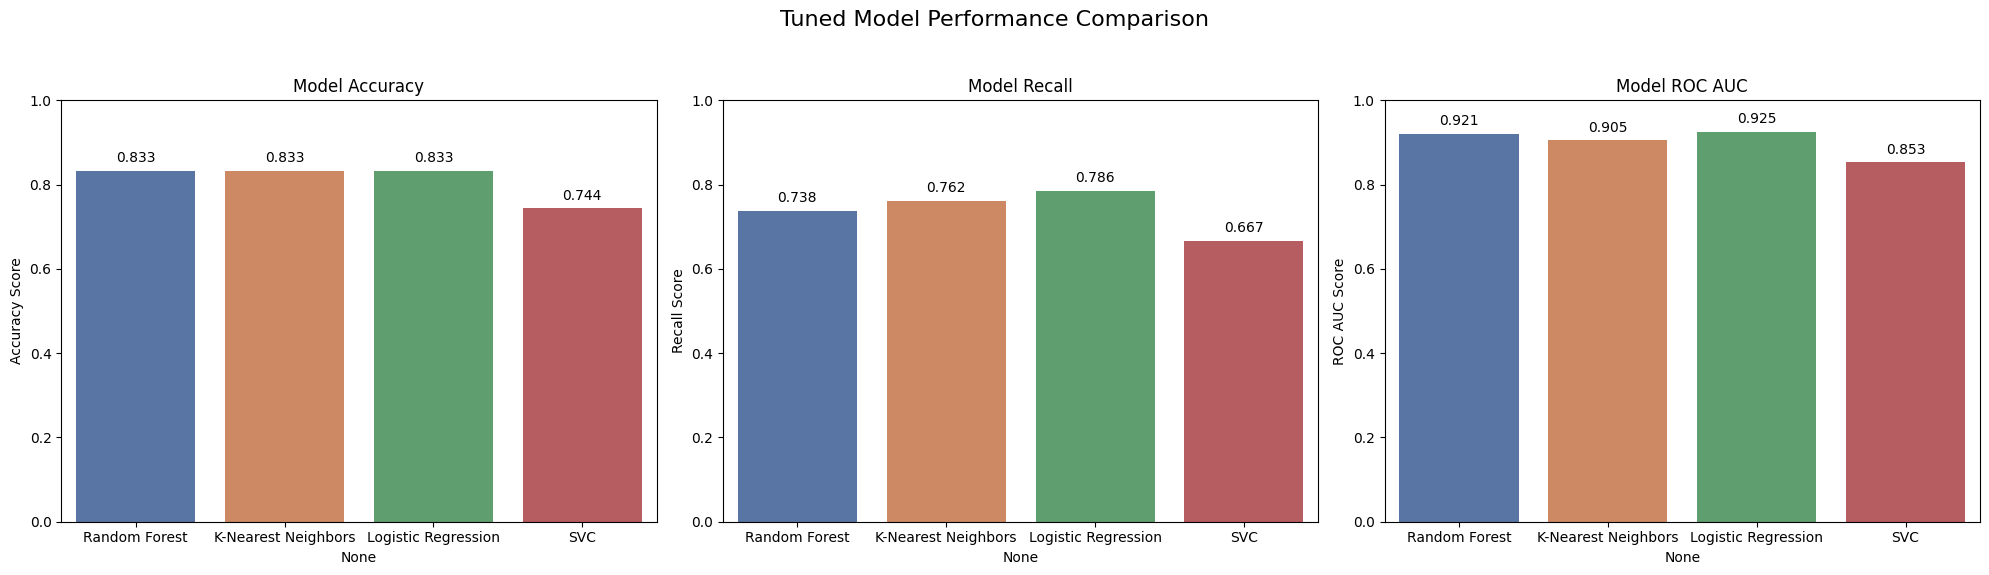


--- Confusion Matrices ---


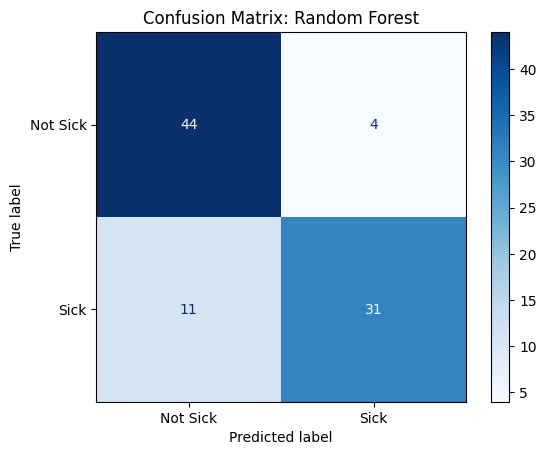

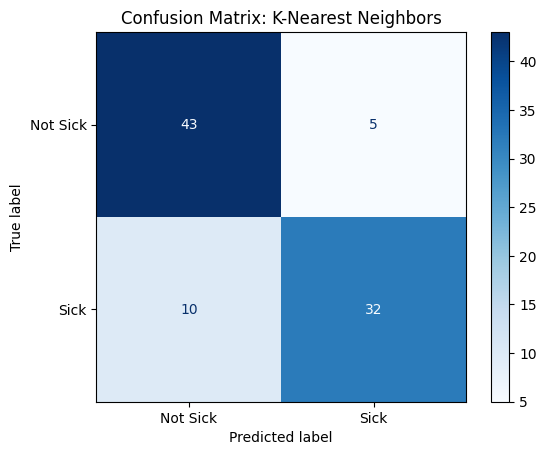

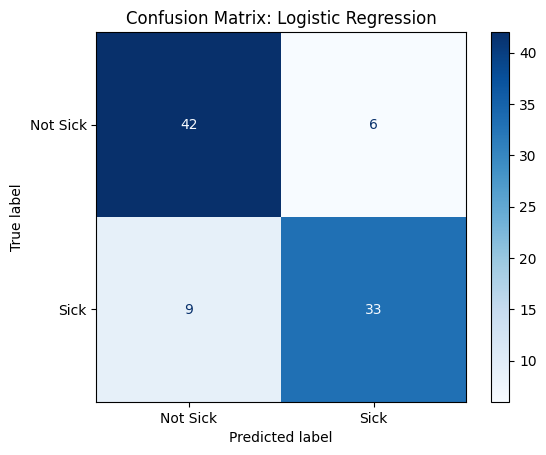

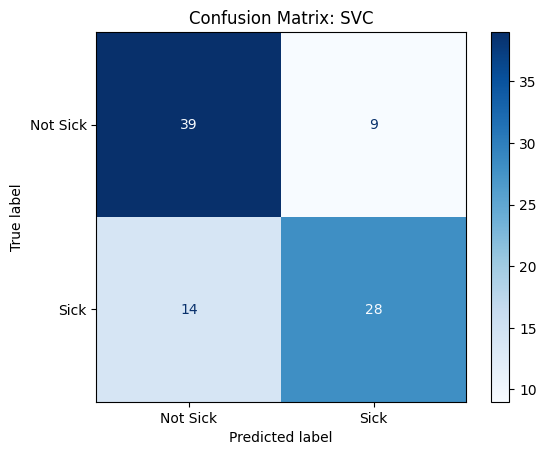


--- Summary of Tuned Model Performance on Test Set ---
                     Accuracy  Recall  ROC AUC
Random Forest           0.833   0.738    0.921
K-Nearest Neighbors     0.833   0.762    0.905
Logistic Regression     0.833   0.786    0.925
SVC                     0.744   0.667    0.853

Model with Highest Recall:
Logistic Regression (0.786)


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import recall_score, accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Ensure the models are defined from previous cells (running the full notebook)
# If you're running this section separately, make sure these models are available in your environment:
# best_forest_model, best_knn_model, best_log_model, best_svc_model
# X_test, y_test, X_test_scaled

# Define the models and their corresponding test data
models = {
    "Random Forest": {"model": best_forest_model, "X_test": X_test},
    "K-Nearest Neighbors": {"model": best_knn_model, "X_test": X_test_scaled},
    "Logistic Regression": {"model": best_log_model, "X_test": X_test_scaled},
    "SVC": {"model": best_svc_model, "X_test": X_test_scaled}
}

# Dictionaries to store metrics
accuracy_scores = {}
recall_scores = {}
roc_auc_scores = {}

# Calculate metrics for each model
for name, data in models.items():
    model = data["model"]
    X_test_data = data["X_test"]
    
    y_pred = model.predict(X_test_data)
    
    accuracy_scores[name] = accuracy_score(y_test, y_pred)
    recall_scores[name] = recall_score(y_test, y_pred)
    
    # Check for predict_proba for ROC AUC
    if hasattr(model, 'predict_proba'):
        try:
            y_pred_proba = model.predict_proba(X_test_data)[:, 1]
            roc_auc_scores[name] = roc_auc_score(y_test, y_pred_proba)
        except AttributeError:
            roc_auc_scores[name] = np.nan # Not applicable
            print(f"Warning: {name} does not support predict_proba for ROC AUC calculation.")
    else:
        roc_auc_scores[name] = np.nan # Not applicable

# Convert to pandas Series for easy plotting
accuracy_series = pd.Series(accuracy_scores)
recall_series = pd.Series(recall_scores)
roc_auc_series = pd.Series(roc_auc_scores)

# ### 10.1 Comparison of Accuracy, Recall, and ROC AUC

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Tuned Model Performance Comparison', fontsize=16)

# Accuracy Plot
sns.barplot(x=accuracy_series.index, y=accuracy_series.values, ax=axes[0], hue=accuracy_series.index, palette='deep')
axes[0].set_title('Model Accuracy')
axes[0].set_ylabel('Accuracy Score')
axes[0].set_ylim(0, 1)
for index, value in enumerate(accuracy_series.values):
    axes[0].text(index, value + 0.02, f'{value:.3f}', ha='center')

# Recall Plot
sns.barplot(x=recall_series.index, y=recall_series.values, ax=axes[1], hue=recall_series.index, palette='deep')
axes[1].set_title('Model Recall')
axes[1].set_ylabel('Recall Score')
axes[1].set_ylim(0, 1)
for index, value in enumerate(recall_series.values):
    axes[1].text(index, value + 0.02, f'{value:.3f}', ha='center')

# ROC AUC Plot
# Filter out NaNs if some models don't have predict_proba
roc_auc_filtered_series = roc_auc_series.dropna()
if not roc_auc_filtered_series.empty:
    sns.barplot(x=roc_auc_filtered_series.index, y=roc_auc_filtered_series.values, ax=axes[2], hue=roc_auc_filtered_series.index, palette='deep')
    axes[2].set_title('Model ROC AUC')
    axes[2].set_ylabel('ROC AUC Score')
    axes[2].set_ylim(0, 1)
    for index, value in enumerate(roc_auc_filtered_series.values):
        axes[2].text(index, value + 0.02, f'{value:.3f}', ha='center')
else:
    axes[2].set_title('Model ROC AUC (Not Available)')
    axes[2].text(0.5, 0.5, "No models support predict_proba for ROC AUC", 
                 horizontalalignment='center', verticalalignment='center', transform=axes[2].transAxes)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()


# ### 10.2 Confusion Matrices for Each Model

# Function to plot confusion matrix
def plot_confusion_matrix(model, X_test_data, y_test_data, title):
    y_pred = model.predict(X_test_data)
    cm = confusion_matrix(y_test_data, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Sick', 'Sick'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Confusion Matrix: {title}')
    plt.show()

# Plot confusion matrices for each model
print("\n--- Confusion Matrices ---")
for name, data in models.items():
    plot_confusion_matrix(data["model"], data["X_test"], y_test, name)

# ### 10.3 Combined Performance Table

# Create a DataFrame to summarize all metrics
performance_df = pd.DataFrame({
    'Accuracy': accuracy_series,
    'Recall': recall_series,
    'ROC AUC': roc_auc_series
})

print("\n--- Summary of Tuned Model Performance on Test Set ---")
print(performance_df.round(3))

# Highlight the best recall score (or other preferred metric)
print("\nModel with Highest Recall:")
print(performance_df['Recall'].idxmax(), f"({performance_df['Recall'].max():.3f})")

# %%

## Model Interpretability and Feature Importance

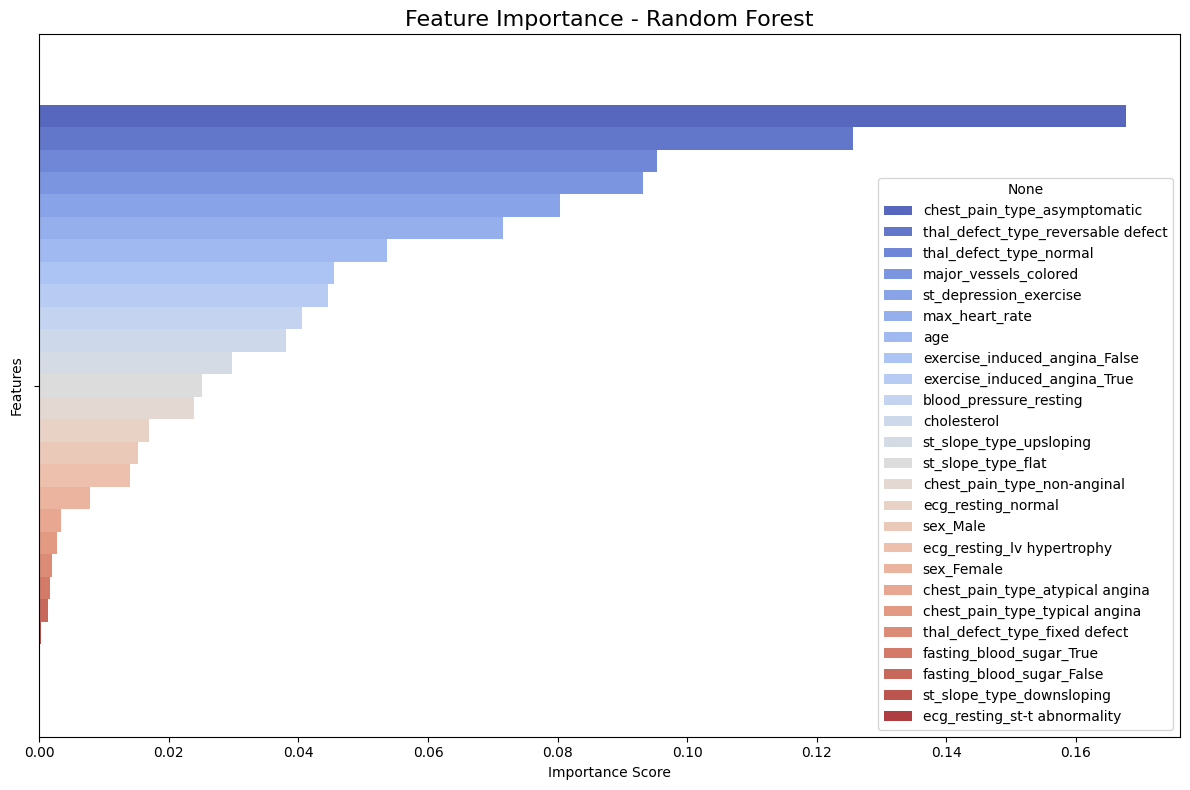

In [28]:
# Get feature importances from the best Random Forest model
importances = best_forest_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for visualization
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x=forest_importances, hue=forest_importances.index, palette='coolwarm')
plt.title('Feature Importance - Random Forest', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

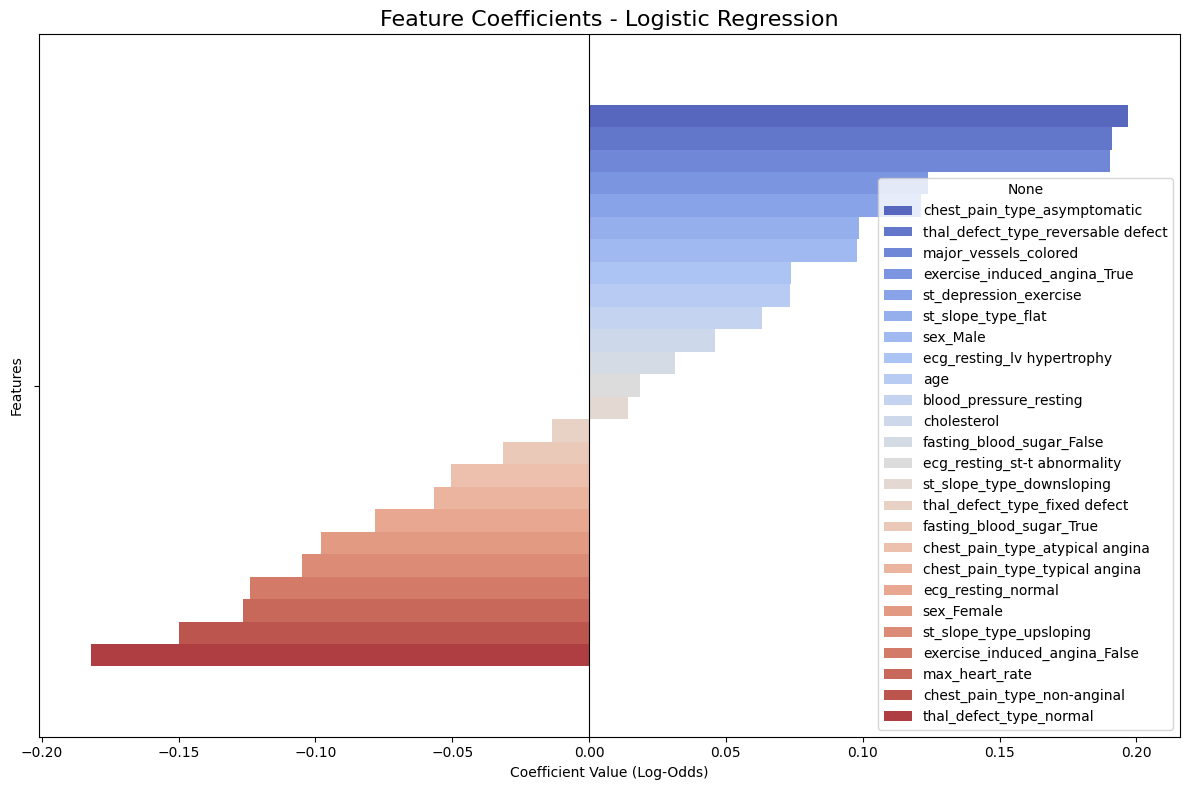

In [31]:
# Get coefficients from the best Logistic Regression model
# The model was trained on scaled data, so we use the same feature names
log_coeffs = pd.DataFrame(
    best_log_model.coef_[0],
    index=X_train.columns,
    columns=['Coefficient']
).sort_values(by='Coefficient', ascending=False)

# Plot the coefficients
plt.figure(figsize=(12, 8))
sns.barplot(x=log_coeffs['Coefficient'], hue=log_coeffs.index, palette='coolwarm')
plt.title('Feature Coefficients - Logistic Regression', fontsize=16)
plt.xlabel('Coefficient Value (Log-Odds)')
plt.ylabel('Features')
plt.axvline(0, color='black', lw=0.8)
plt.tight_layout()
plt.show()

### Global Model Interpretation with SHAP

In [32]:
import shap

explainer = shap.KernelExplainer(best_log_model.predict, shap.kmeans(X_train_scaled, 10), feature_names=X_train_scaled_df.columns)
shap_values = explainer.shap_values(X_test_scaled)
# print(shap_values)

ModuleNotFoundError: No module named 'shap'

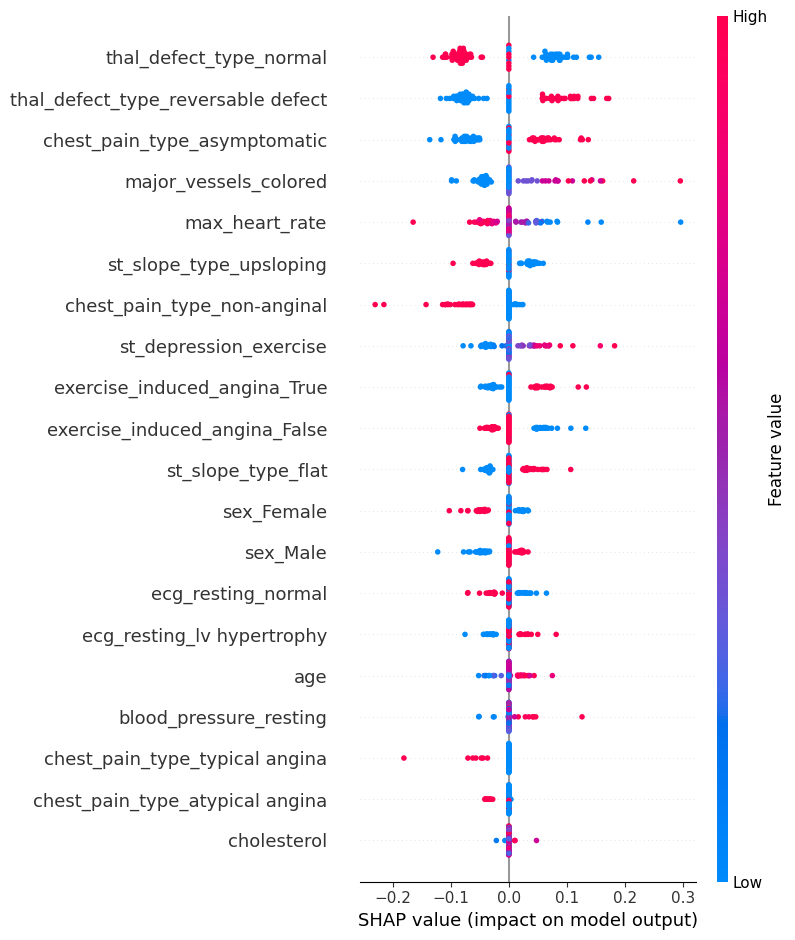

In [ ]:
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_train.columns)

In [ ]:
X_train.head()

,sex_Female,sex_Male,chest_pain_type_asymptomatic,chest_pain_type_atypical angina,chest_pain_type_non-anginal,chest_pain_type_typical angina,fasting_blood_sugar_False,fasting_blood_sugar_True,ecg_resting_lv hypertrophy,ecg_resting_normal,...,st_slope_type_upsloping,thal_defect_type_fixed defect,thal_defect_type_normal,thal_defect_type_reversable defect,age,blood_pressure_resting,cholesterol,max_heart_rate,st_depression_exercise,major_vessels_colored
id,,,,,,,,,,,,,,,,,,,,,
206,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,45.0,142.0,309.0,147.0,0.0,3.0
219,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,64.0,130.0,303.0,122.0,2.0,2.0
187,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,42.0,120.0,240.0,194.0,0.8,0.0
96,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,52.0,128.0,255.0,161.0,0.0,1.0
135,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,43.0,122.0,213.0,165.0,0.2,0.0


## GPT Predictions

In [ ]:
gpt_df = pd.read_csv('../data/heart_disease_gpt_prediction.csv')

In [ ]:
gpt_df.head()

,id,age,sex,dataset,chest_pain_type,blood_pressure_resting,cholesterol,fasting_blood_sugar,ecg_resting,max_heart_rate,exercise_induced_angina,st_depression_exercise,st_slope_type,major_vessels_colored,thal_defect_type,heart_disease_prediction,sick,gpt_prediction
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0,0,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2,1,1
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1,1,0
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0,0,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0,0,0


In [ ]:
from sklearn.metrics import accuracy_score, recall_score

# Calculate accuracy and recall between 'score' and 'gpt_prediction' columns
accuracy = accuracy_score(gpt_df['sick'], gpt_df['gpt_prediction'])
recall = recall_score(gpt_df['sick'], gpt_df['gpt_prediction'])

print(f"gpt Prediction Accuracy: {accuracy:.3f}")
print(f"gpt Prediction Recall: {recall:.3f}")

gpt Prediction Accuracy: 0.645
gpt Prediction Recall: 0.281


<Figure size 800x600 with 0 Axes>

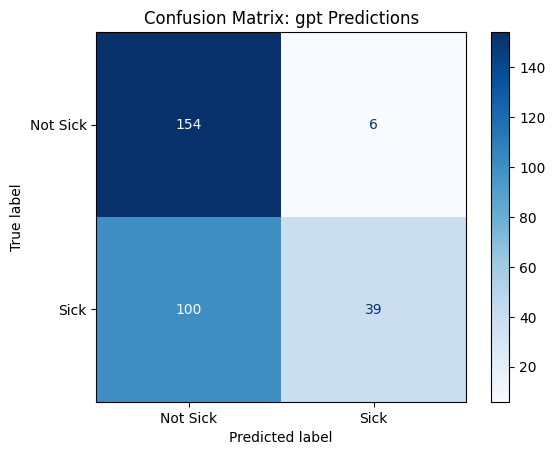


Classification Report for gpt Predictions:
              precision    recall  f1-score   support

    Not Sick       0.61      0.96      0.74       160
        Sick       0.87      0.28      0.42       139

    accuracy                           0.65       299
   macro avg       0.74      0.62      0.58       299
weighted avg       0.73      0.65      0.60       299



In [ ]:
# Create confusion matrix for gpt predictions
cm_gpt = confusion_matrix(gpt_df['sick'], gpt_df['gpt_prediction'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_gpt, display_labels=['Not Sick', 'Sick'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix: gpt Predictions')
plt.show()

# Print classification report for more detailed metrics
print("\nClassification Report for gpt Predictions:")
print(classification_report(gpt_df['sick'], gpt_df['gpt_prediction'], target_names=['Not Sick', 'Sick']))